In [1]:
import graphviz 
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import tree

import utils

from utils import local_data
from utils import window
from utils import Scale, give_error
from utils import smooth_signal
from utils import location_station, find_set_sunrise, find_set_sunset

%matplotlib inline
warnings.filterwarnings('ignore')

latter_size = 14
plt.rcParams['legend.fontsize'] = latter_size 
plt.rcParams['font.size'] = latter_size 
plt.rcParams['axes.labelsize'] = latter_size
plt.rcParams['xtick.labelsize'] = latter_size
plt.rcParams['ytick.labelsize'] = latter_size

In [2]:
df = pd.read_pickle('./data/sj2_analise.pkl')

In [3]:
df.head()

,vtec,vtec_dt,vtec_dt2,gvtec1,gvtec1_dt,gvtec2,gvtec2_dt,s4
2013-12-01 03:30:00,33.624428,-0.428246,-0.020502,-3.216613,0.002355,1.826065,1.991653,0.163334
2013-12-01 03:40:00,33.205025,-0.546589,-0.118343,-3.122300,0.130198,4.588494,2.530373,0.165397
2013-12-01 03:50:00,32.539631,-0.772594,-0.226005,-2.810556,0.280756,7.786990,2.862830,0.168683
2013-12-01 04:00:00,31.469337,-1.082859,-0.310265,-2.320938,0.399753,10.972091,2.894375,0.173552
2013-12-01 04:10:00,29.995466,-1.429647,-0.346788,-1.764129,0.443303,13.734955,2.621609,0.178917


### (1) Estimação de s4 com vtec

The scores for the k-fold crossvalidation was:
[-0.00302293 -0.00244031 -0.00301779 -0.00281619 -0.00314596 -0.00310809
 -0.00289349 -0.00290457 -0.00364187 -0.00302778] 

O erro quadrático médio foi: 0.002777
O erro quadrático total foi: 3.161611
O maior erro por previsão foi: 0.398483
O erro relativo foi: 12.675948%
O número de verdadeiros negativos foi: 2793
O número de verdadeiros positivos foi: 130
O número de falsos negativos foi: 247
O número de falsos positivos foi: 430
O POD foi: 0.344828
O FAR foi: 0.767857
A ACC foi: 0.811944
O kappa foi: 0.057544

Error for the time series sample:
O erro quadrático médio foi: 0.008751
O erro quadrático total foi: 2.430469
O maior erro por previsão foi: 0.591792
O erro relativo foi: 15.560212%
O número de verdadeiros negativos foi: 537
O número de verdadeiros positivos foi: 23
O número de falsos negativos foi: 61
O número de falsos positivos foi: 54
O POD foi: 0.273810
O FAR foi: 0.701299
A ACC foi: 0.829630
O kappa foi: 0.074621


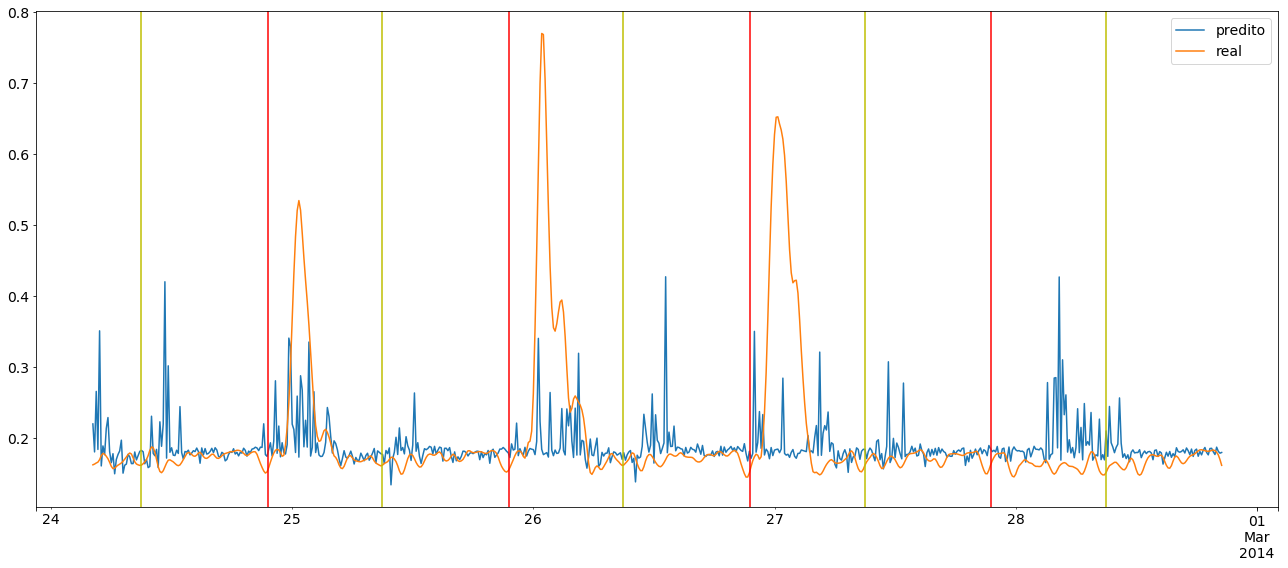

In [4]:
instances_set = ['vtec']
scaler = StandardScaler()
scaler.fit(X=df[instances_set].values) 
X = scaler.transform(X=df[instances_set].values)
y = df['s4'].values

X_train, X_test, y_train, y_test = train_test_split(X[0:12000], y[0:12000], test_size=0.30, random_state=42)
index = df.index.values[12000:12772]

# generate model, use k-fold crossvalidation and print scores
model = RandomForestRegressor()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('The scores for the k-fold crossvalidation was:')
print(scores, '\n')

# generate final model, and avaliate a test set
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
give_error(y_test, y_predict);
print()

# use the final model to avaliate the error in a sample of the time series
df_aux = pd.DataFrame(index=index)
df_aux['predito'] = model.predict(X[12000:12772])
df_aux['real'] = y[12000:12772]

print('Error for the time series sample:')
give_error(df_aux['real'].values, df_aux['predito'].values);

# plot the time series predict against the real values
ax = df_aux.plot(figsize=(18, 8));

lat, long = location_station('sj2')
set_of_sunrise = find_set_sunrise(df_aux, lat, long)
set_of_sunset = find_set_sunset(df_aux, lat, long)
for i in set_of_sunrise:
    ax.axvline(x=i, color='y')
for i in set_of_sunset[0:-1]:
    ax.axvline(x=i, color='r')

plt.tight_layout()
plt.savefig('./images/regression_random_florest_1.eps', format='eps', dpi=1000)

### (2) Estimação de s4 com vtec, vtec_dt e vtec_dt2

The scores for the k-fold crossvalidation was:
[-0.00162297 -0.0015881  -0.00181376 -0.00224994 -0.00232161 -0.00251901
 -0.00218362 -0.00199769 -0.00215618 -0.0021715 ] 

O erro quadrático médio foi: 0.001806
O erro quadrático total foi: 2.549802
O maior erro por previsão foi: 0.383677
O erro relativo foi: 10.083653%
O número de verdadeiros negativos foi: 2814
O número de verdadeiros positivos foi: 240
O número de falsos negativos foi: 137
O número de falsos positivos foi: 409
O POD foi: 0.636605
O FAR foi: 0.630200
A ACC foi: 0.848333
O kappa foi: 0.037321

Error for the time series sample:
O erro quadrático médio foi: 0.007254
O erro quadrático total foi: 2.212726
O maior erro por previsão foi: 0.526276
O erro relativo foi: 17.189899%
O número de verdadeiros negativos foi: 489
O número de verdadeiros positivos foi: 59
O número de falsos negativos foi: 25
O número de falsos positivos foi: 102
O POD foi: 0.702381
O FAR foi: 0.633540
A ACC foi: 0.811852
O kappa foi: 0.040040


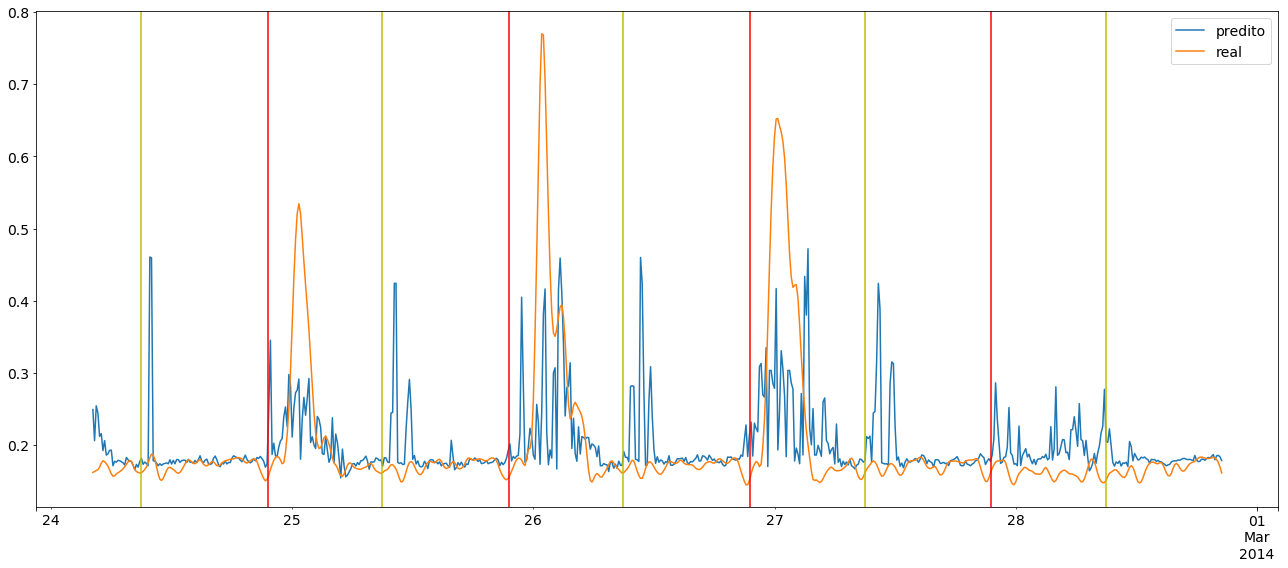

In [5]:
instances_set = ['vtec', 'vtec_dt', 'vtec_dt2']
scaler = StandardScaler()
scaler.fit(X=df[instances_set].values) 
X = scaler.transform(X=df[instances_set].values)
y = df['s4'].values

X_train, X_test, y_train, y_test = train_test_split(X[0:12000], y[0:12000], test_size=0.30, random_state=42)
index = df.index.values[12000:12772]

# generate model, use k-fold crossvalidation and print scores
model = RandomForestRegressor()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('The scores for the k-fold crossvalidation was:')
print(scores, '\n')

# generate final model, and avaliate a test set
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
give_error(y_test, y_predict);
print()

# use the final model to avaliate the error in a sample of the time series
df_aux = pd.DataFrame(index=index)
df_aux['predito'] = model.predict(X[12000:12772])
df_aux['real'] = y[12000:12772]

print('Error for the time series sample:')
give_error(df_aux['real'].values, df_aux['predito'].values);

# plot the time series predict against the real values
ax = df_aux.plot(figsize=(18, 8));

lat, long = location_station('sj2')
set_of_sunrise = find_set_sunrise(df_aux, lat, long)
set_of_sunset = find_set_sunset(df_aux, lat, long)
for i in set_of_sunrise:
    ax.axvline(x=i, color='y')
for i in set_of_sunset[0:-1]:
    ax.axvline(x=i, color='r')

plt.tight_layout()
plt.savefig('./images/regression_random_florest_2.eps', format='eps', dpi=1000)

### (3) Estimação de S4 com vtec, gvtec1 e gvtec2

The scores for the k-fold crossvalidation was:
[-0.00159188 -0.00133761 -0.00158959 -0.00178082 -0.00162217 -0.00157809
 -0.00174576 -0.00157849 -0.0016018  -0.00170598] 

O erro quadrático médio foi: 0.001473
O erro quadrático total foi: 2.302905
O maior erro por previsão foi: 0.375418
O erro relativo foi: 8.751760%
O número de verdadeiros negativos foi: 2914
O número de verdadeiros positivos foi: 255
O número de falsos negativos foi: 122
O número de falsos positivos foi: 309
O POD foi: 0.676393
O FAR foi: 0.547872
A ACC foi: 0.880278
O kappa foi: 0.033511

Error for the time series sample:
O erro quadrático médio foi: 0.006712
O erro quadrático total foi: 2.128527
O maior erro por previsão foi: 0.573150
O erro relativo foi: 14.913532%
O número de verdadeiros negativos foi: 528
O número de verdadeiros positivos foi: 48
O número de falsos negativos foi: 36
O número de falsos positivos foi: 63
O POD foi: 0.571429
O FAR foi: 0.567568
A ACC foi: 0.853333
O kappa foi: 0.048356


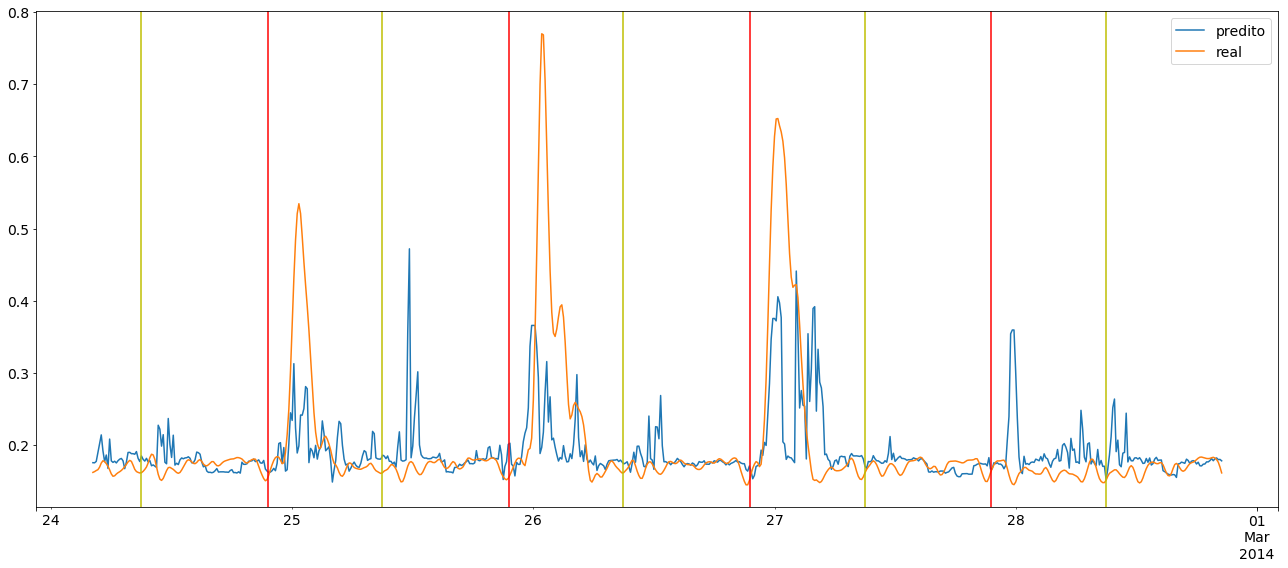

In [6]:
instances_set = ['vtec', 'gvtec1', 'gvtec2']
scaler = StandardScaler()
scaler.fit(X=df[instances_set].values) 
X = scaler.transform(X=df[instances_set].values)
y = df['s4'].values

X_train, X_test, y_train, y_test = train_test_split(X[0:12000], y[0:12000], test_size=0.30, random_state=42)
index = df.index.values[12000:12772]

# generate model, use k-fold crossvalidation and print scores
model = RandomForestRegressor()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('The scores for the k-fold crossvalidation was:')
print(scores, '\n')

# generate final model, and avaliate a test set
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
give_error(y_test, y_predict);
print()

# use the final model to avaliate the error in a sample of the time series
df_aux = pd.DataFrame(index=index)
df_aux['predito'] = model.predict(X[12000:12772])
df_aux['real'] = y[12000:12772]

print('Error for the time series sample:')
give_error(df_aux['real'].values, df_aux['predito'].values);

# plot the time series predict against the real values
ax = df_aux.plot(figsize=(18, 8));

lat, long = location_station('sj2')
set_of_sunrise = find_set_sunrise(df_aux, lat, long)
set_of_sunset = find_set_sunset(df_aux, lat, long)
for i in set_of_sunrise:
    ax.axvline(x=i, color='y')
for i in set_of_sunset[0:-1]:
    ax.axvline(x=i, color='r')

plt.tight_layout()
plt.savefig('./images/regression_random_florest_3.eps', format='eps', dpi=1000)